In [182]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline as interpolate

#exo = pd.read_csv('data/exoplanets.csv')
#exo.to_hdf('data/exoplanets.h5','df')
exo = pd.read_hdf('data/exoplanets.h5', 'df')

m_nep = 0.0539531012
r_nep = 0.35219064

# Set dates for KOIs
# KOI -> 1609: 2011
# -> 2841: 2012
# -> 3149: 2012.5
# -> 4914: 2013
# -> 6251: 2014
# -> 7620: 2015
B11 = exo.KOI < 1610# & kepname
Q6 = exo.KOI <= 2841# & kepname
Q8 = exo.KOI <= 3149# & kepname
Q12 = exo.KOI <= 4914# & kepname
Q16 = exo.KOI <= 6251# & kepname
Q17 = exo.KOI <= 7620# & kepname

exo.loc[Q17, 'DATE'] = 2015
exo.loc[Q16, 'DATE'] = 2014
exo.loc[Q12, 'DATE'] = 2013
exo.loc[Q8, 'DATE'] = 2012.5
exo.loc[Q6, 'DATE'] = 2012
exo.loc[B11, 'DATE'] = 2011

kepname = (exo.NAME.str.contains('Kepler')).values
koiname = (exo.NAME.str.contains('KOI')).values

kepler = exo[kepname].copy()
koi = exo[koiname].copy()
all_kepler = exo[koiname | kepname].copy()
no_kepler = exo[~(kepname | koiname)].copy()

In [301]:
exo.query("STARDISCMETH=='Timing'")[['NAME','DATE']]

,NAME,DATE
4,NN Ser d,2010
95,Kepler-79 b,2011
209,NN Ser c,2010
242,PSR B1257+12 B,1992
577,Kepler-87 b,2011
580,PSR B1257+12 C,1994
1090,PSR B1257+12 A,1992
1395,Kepler-79 c,2011
1499,Kepler-87 c,2011


In [15]:
exo[['DATE','NAME']].head()

,DATE,NAME
0,2014,Kepler-107 d
1,2010,Kepler-427 b
2,2009,WASP-14 b
3,2011,Kepler-50 b
4,2010,NN Ser d


In [315]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    


def cum_draw(df=exo,color='k',mindate=1995,maxdate=2015,ax=None,norm=False,fill=True, kois=False,
             alpha=0.2,interp=False,kepler=False,kepsmall=False,label=False,xylabel=(0.1,0.8),
            zorder=0):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    else:
        fig = ax.figure

    dates = np.sort(df.DATE)
    ds = np.unique(dates).astype(float)
    ds = ds[ds <= maxdate]
    ns = np.zeros(len(ds))
    for i,d in enumerate(ds):
        ns[i] = (dates<=d).sum()
    if norm:
        ns /= ns.max()
        ns *= norm
    
    if interp:
        dgrid = np.arange(mindate,maxdate,0.1)
        fn = interpolate(ds,ns,s=0)
        y1 = fn(dgrid)
        y2 = -y1
    else:
        dgrid = ds
        y1 = ns
        y2 = -ns
    #ax.plot(dgrid,y1,color=color)
    #ax.plot(dgrid,y2,color=color)
    ax.fill_between(dgrid,y1,y2,alpha=alpha,color=color, zorder=zorder)
    ax.set_xlim(xmin=mindate,xmax=maxdate)
    ax.set_yticks([])
    
    date_ticks = np.arange(mindate,maxdate+1,2)
    
    #for d in date_ticks:
    #    ax.axvline(d, ls=':', color='k', alpha=0.2)
    ax.set_xticks(date_ticks)
    ax.tick_params(labelsize=16)
    
    ax.spines["top"].set_visible(False)    
    #ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  
    
    ax.get_xaxis().tick_bottom()    
    ax.xaxis.set_tick_params(width=3, length=10)
    
    if label:
        if type(label)==str:
            label = '%s (%i)' % (label,ns.max())
        else:
            label = '{:.0f}'.format(ns.max())
        plt.annotate(label,xy=xylabel,xycoords='axes fraction',fontsize=18,color=color)

    #print ns, ds
    return fig
        

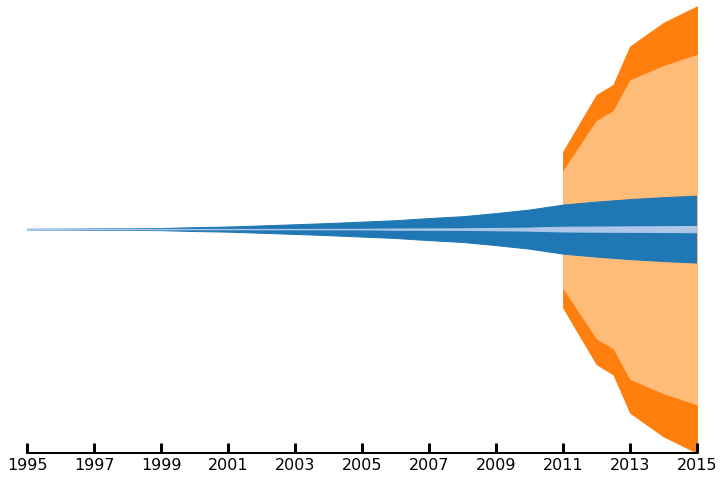

In [316]:
m_nep = 0.0539531012
r_nep = 2.4622e9 / 6.9911e9

no_kepler_small = no_kepler.query('MASS < {}'.format(m_nep))
all_kepler_small = all_kepler.query('R < {}'.format(r_nep))

fig, ax = plt.subplots(1,1, figsize=(12,8))

subsets = [no_kepler, no_kepler_small, all_kepler, all_kepler_small]
n = len(subsets)

for i,d in enumerate(subsets):
    fig = cum_draw(d, ax=ax, color=tableau20[i], alpha=1, zorder=-len(d));

fig.savefig('planet_wedge.png', transparent=True, bbox_inches="tight")
    

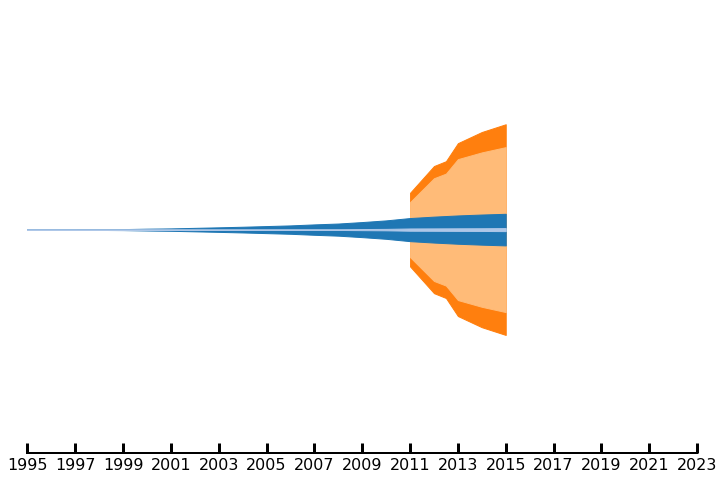

In [318]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

subsets = [no_kepler, no_kepler_small, all_kepler, all_kepler_small]
n = len(subsets)

for i,d in enumerate(subsets):
    fig = cum_draw(d, ax=ax, color=tableau20[i], alpha=1, zorder=-len(d), maxdate=2023);

ax.set_ylim((-10000,10000))
fig.savefig('planet_wedge_future.png', transparent=True, bbox_inches="tight");
    

[   1.    2.    4.    5.    6.    7.    9.   14.   16.   22.   41.   54.
   78.  102.  128.  158.  188.  233.  272.  338.] [ 1988.  1989.  1992.  1993.  1994.  1995.  1996.  1997.  1998.  1999.
  2000.  2001.  2002.  2003.  2004.  2005.  2006.  2007.  2008.  2009.]
[  2.   3.   5.   7.  13.  15.  16.  25.] [ 1992.  1994.  2004.  2005.  2006.  2007.  2008.  2009.]


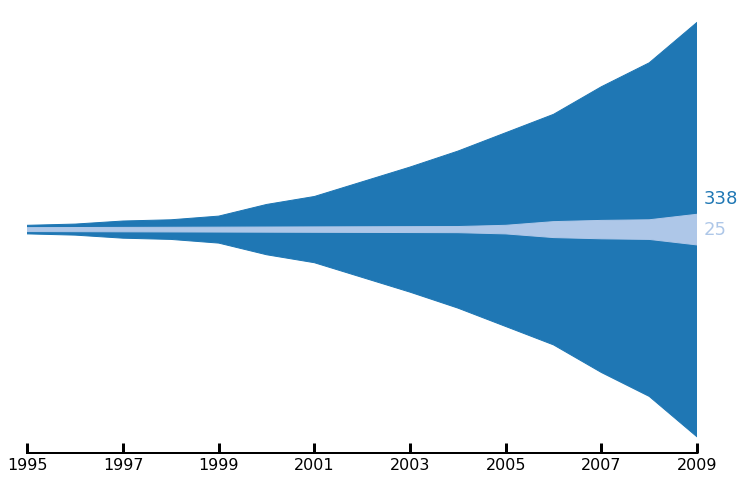

In [307]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

subsets = [no_kepler, no_kepler_small]

for i,d in enumerate(subsets):
    cum_draw(d, maxdate=2009, ax=ax, color=tableau20[i], alpha=1, label=True,
            xylabel=(1.01,0.56-i*0.07))
ax.set_ylim((-708/2-10,708/2+10));

fig.savefig('prekepler_wedge.png', transparent=True, bbox_inches="tight")

In [302]:
len(no_kepler_small.query('DATE<=2009'))

25

In [303]:
len(no_kepler.query('DATE <= 2009'))

338

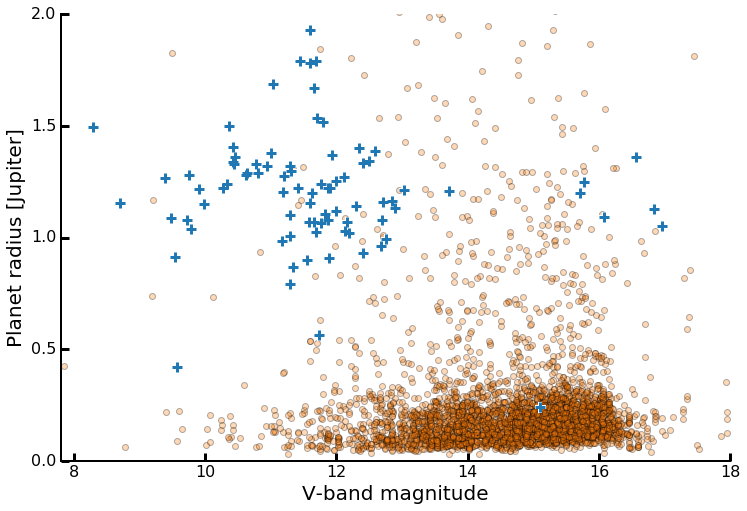

In [295]:
from keputils import koiutils as ku
from astropy import constants as const

RJUP = const.R_jup.cgs.value
REARTH = const.R_earth.cgs.value

DR24 = ku.DR24.query('koi_disposition != "FALSE POSITIVE"')
DR24.Vmag = DR24.koi_gmag - 0.59*(DR24.koi_gmag - DR24.koi_rmag) - 0.01

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)  
#ax.spines["left"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

ground_pre_kepler = ~(exo.NAME.str.contains('Kepler') |
                       exo.NAME.str.contains('KOI') |
                       exo.NAME.str.contains('CoRoT')) & (exo.DATE < 2012) & (exo.STARDISCMETH=='Transit')

ax.plot(exo[ground_pre_kepler].V, exo[ground_pre_kepler].R, '+', color='w', ms=11, mew=4, zorder=2)
ax.plot(exo[ground_pre_kepler].V, exo[ground_pre_kepler].R, '+', color=tableau20[0], ms=10, mew=3, zorder=2)
ax.plot(DR24.Vmag, DR24.koi_prad*REARTH/RJUP, 'o', color=tableau20[2], mew=1, alpha=0.3, zorder=1)
ax.set_ylim(ymin=0, ymax=2)
ax.set_xlim(xmin=7.8, xmax=18)
ax.xaxis.set_tick_params(width=3, length=8)
ax.yaxis.set_tick_params(width=3, length=8)
ax.tick_params(labelsize=16)

ax.set_xlabel('V-band magnitude', size=20);
ax.set_ylabel('Planet radius [Jupiter]', size=20);
fig.savefig('ground_vs_kep.png', transparent=True, bbox_inches="tight")

In [257]:
5000./55000

0.09090909090909091

In [261]:
3e10/55000. / 1e5

5.454545454545454

In [265]:
1e3/2e5

0.005

In [319]:
1e9*0.2 * 0.01 * 0.1

200000.0